<a href="https://colab.research.google.com/github/chasubeen/Store-Sales-Forecasting/blob/%EC%88%98%EB%B9%88/3_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. 패키지 로딩**

In [ ]:
### 기본
import numpy as np
import pandas as pd
import os
import gc
import warnings

### 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # 동적 시각화

## 옵션 설정
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

### 시계열 분석 패키지(ACF, PACF)
import statsmodels.api as sm

# **1. 데이터 불러오기**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA 8기/OB/winter_proj/data/train_preprocessed.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA 8기/OB/winter_proj/data/test_preprocessed.csv')

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,Quito,Pichincha,D,13,93.14,0.00,National
1,1,2013-01-01,41,SEAFOOD,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National
2,2,2013-01-01,41,SCHOOL AND OFFICE SUPPLIES,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National
3,3,2013-01-01,41,PRODUCE,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National
4,4,2013-01-01,41,PREPARED FOODS,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National


In [ ]:
test.head()

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,holiday
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.80,Weekday
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.80,Weekday
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.80,Weekday
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.80,Weekday
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.80,Weekday


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705087 entries, 0 to 2705086
Data columns (total 13 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   float64
 6   city          object 
 7   state         object 
 8   type          object 
 9   cluster       int64  
 10  dcoilwtico    float64
 11  transactions  float64
 12  holiday       object 
dtypes: float64(4), int64(3), object(6)
memory usage: 268.3+ MB


In [ ]:
# date를 datetime 형으로 변경

train['date'] = pd.to_datetime(train['date'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705087 entries, 0 to 2705086
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   float64       
 6   city          object        
 7   state         object        
 8   type          object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  transactions  float64       
 12  holiday       object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(5)
memory usage: 268.3+ MB


- 제대로 변경되었다.

## **📌 Data Description**
| Index | Column        | Description                     |
|-------|---------------|---------------------------------|
| 1     | id            | 각 데이터를 구분하기 위한 식별자|
| 2     | date          |판매일자                         |
| 3     | store_nbr     |매장 고유 식별번호               |
| 4     | family        |판매되는 제품군 유형             |
| 5     | sales         |매출액, **target 변수**        |
| 6     | onpromotion   |프로모션 대상 제품 수            |
| 7     | city          |도시                             |
| 8     | state         |주                               |
| 9     | type          |매장 유형                        |
| 10    | cluster       |유사한 매장들의 군집             |
| 11    | dcoilwtico    |유가(기름값)                     |
| 12    | transactions  |거래량                           |
| 13    | holiday       |공휴일 종류                      |



# **2. EDA**

## **2-1. Target 변수(Sales)**
- 여러 요인에 따라 매출이 어떻게 달라지는지 살펴보자.

### **a) 시도표**

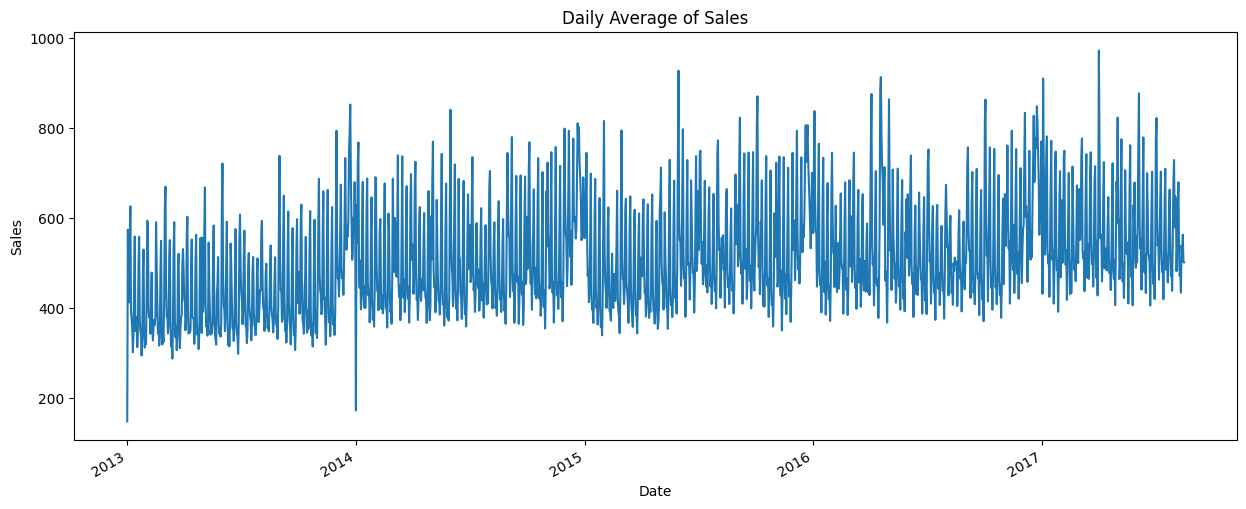

In [ ]:
### 휴업한 날의 데이터 제외
# sales가 0인 데이터 -> 휴업으로 인한 값 => 비정상 데이터이므로 제외

train2 = train[train['sales'] != 0]

# 일별 평균 계산
daily_average = train2.groupby('date')['sales'].mean()

# 시각화
daily_average.plot(figsize=(15, 6))
plt.title('Daily Average of Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

- 추세(Trend)
  - 우상향 추세를 보인다.
  - 향후에도 매출액이 증가할 것이라고 예측할 수 있다.
- 계절성(Seasonality)

- 순환성(Cyclic)

- 불규칙성(Irregularity)
  - 중간중간 휴업으로 인한 불규칙성을 보임
  - 특히 2013, 2014년 초에 급격한 매출 저하를 보이는 구간들이 존재

---

(+) 여기에 ACF, PACF 추가  
(+) 차분 계열 추가?(lag)  

### **b) 시간 관련 변수**
- 시간과 관련된 파생 변수들을 생성해 보자.

In [ ]:
train['year'] = train['date'].dt.year # 연도
train['quarter'] = train['date'].dt.quarter # 분기별
train['month'] = train['date'].dt.month # 월
train['day_of_week'] = train['date'].dt.dayofweek # 요일

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,holiday,year,quarter,month,day_of_week
1427,1427,2013-01-01,25,GROCERY II,15.00,0.00,Salinas,Santa Elena,D,1,93.14,770.00,National,2013,1,1,1
1428,1428,2013-01-01,25,GROCERY I,700.00,0.00,Salinas,Santa Elena,D,1,93.14,770.00,National,2013,1,1,1
1429,1429,2013-01-01,25,FROZEN FOODS,29.65,0.00,Salinas,Santa Elena,D,1,93.14,770.00,National,2013,1,1,1
1430,1430,2013-01-01,25,DELI,71.09,0.00,Salinas,Santa Elena,D,1,93.14,770.00,National,2013,1,1,1
1431,1431,2013-01-01,25,DAIRY,143.00,0.00,Salinas,Santa Elena,D,1,93.14,770.00,National,2013,1,1,1


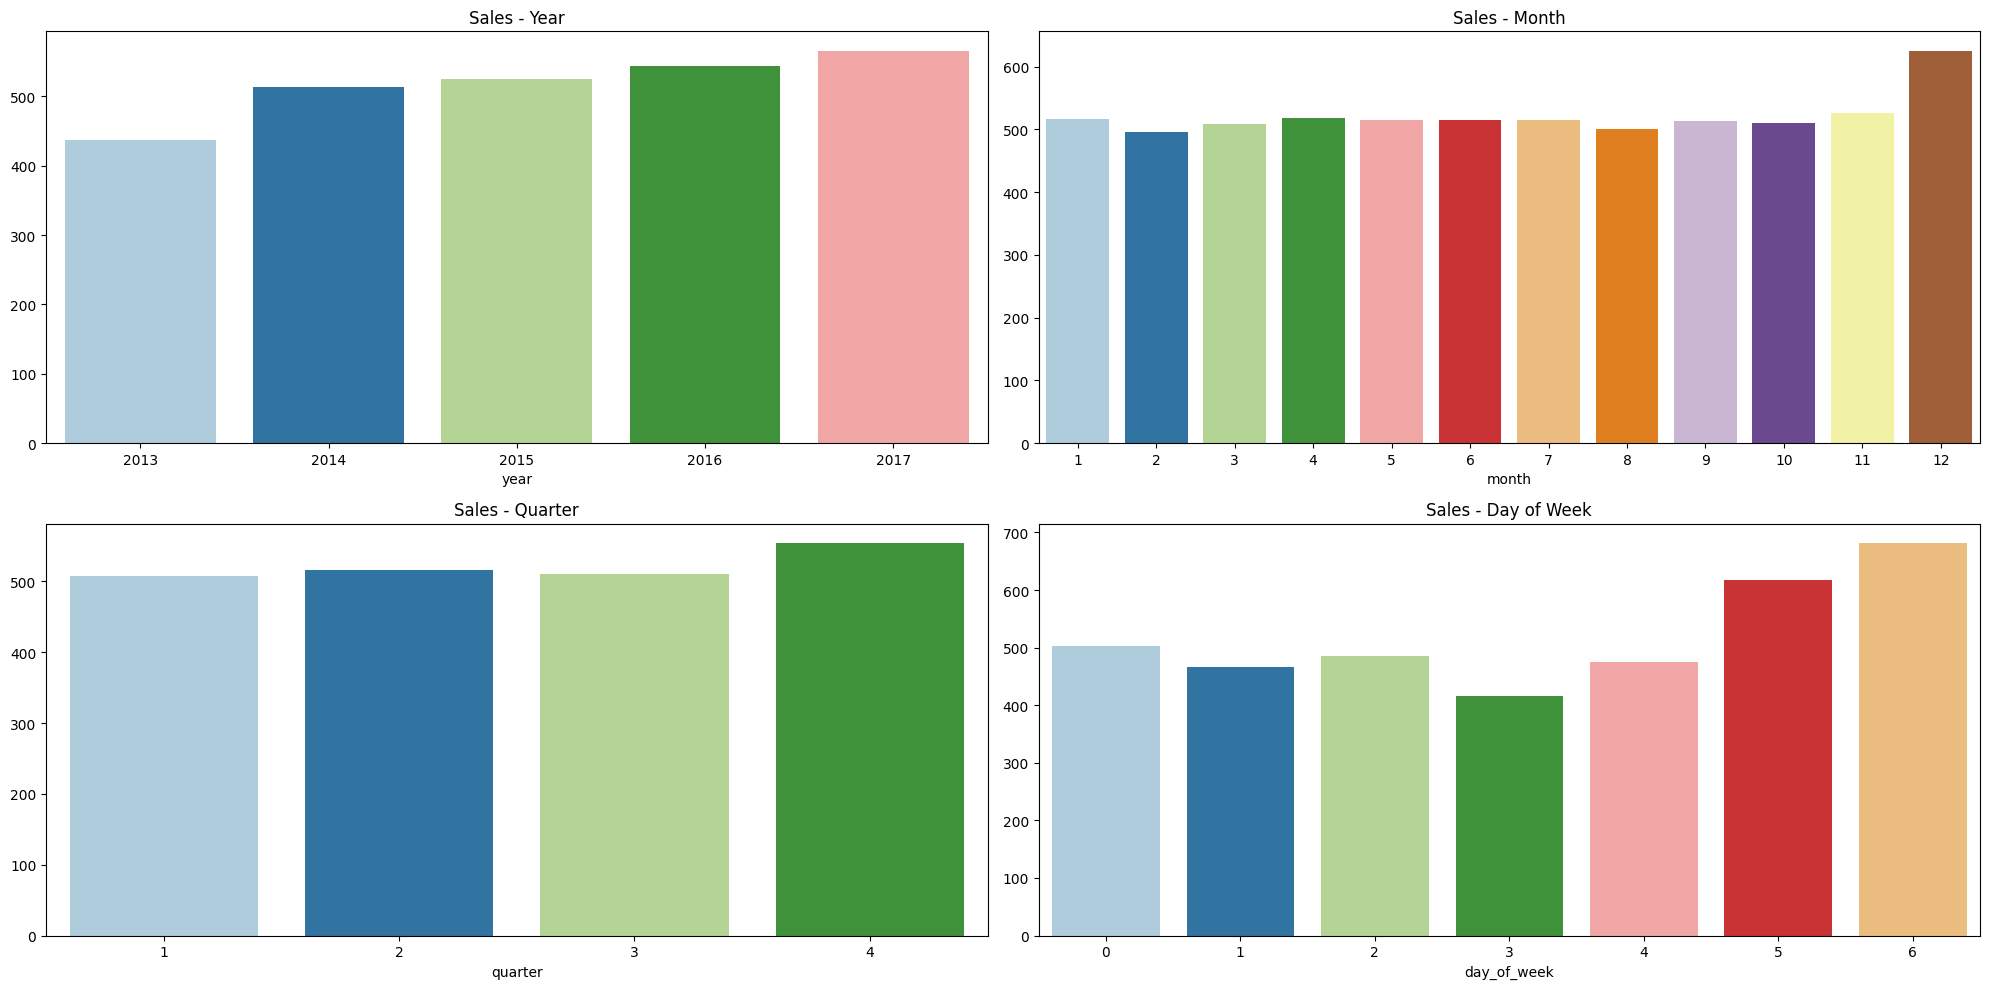

In [ ]:
### 평균 매출액으로 시각화
data_grouped_year = train.groupby(['year']).mean()['sales']
data_grouped_month = train.groupby(['month']).mean()['sales']
data_grouped_quarter = train.groupby(['quarter']).mean()['sales']
data_grouped_day = train.groupby(['day_of_week']).mean()['sales']


palette = sns.color_palette("Paired")


fig, axes = plt.subplots(2, 2, figsize=(20, 10))
# 연도별 매출
axes[0, 0].set_title('Sales - Year')
sns.barplot(x=data_grouped_year.index, y=data_grouped_year.values, ax=axes[0, 0], palette=palette)
# 월별 매출
axes[0, 1].set_title('Sales - Month')
sns.barplot(x=data_grouped_month.index, y=data_grouped_month.values, ax=axes[0, 1], palette=palette)
# 분기별 매출
axes[1, 0].set_title('Sales - Quarter')
sns.barplot(x=data_grouped_quarter.index, y=data_grouped_quarter.values, ax=axes[1, 0], palette=palette)
# 요일별 매출
axes[1, 1].set_title('Sales - Day of Week')
sns.barplot(x=data_grouped_day.index, y=data_grouped_day.values, ax=axes[1, 1], palette=palette)

plt.tight_layout()
plt.show()

**연도별 매출**
- 뒤로 갈수록 매출액이 점점 증가하고 있다.

**월별 & 분기별 매출**  
- 대체로 비슷한 경향을 보이나, 12월에 매출이 증가
- 4분기에 매출 증가

**요일별 매출**  
- 평일에 비해 주말의 매출액이 더 높다.

## **2-2. Feature 변수**
- 각 feature 변수들의 의미와 `sales`에 미치는 영향을 파악해 보자.

### **1️⃣ type**
- `stores.csv`에서 type은 어떻게 구분될 것일까?

In [ ]:
for i in ["A", 'B', 'C', 'D', 'E']:
  print("type {}: {}".format(i, train.loc[(train['type'] == i),'store_nbr'].nunique()))

type A: 9
type B: 8
type C: 15
type D: 18
type E: 4


In [ ]:
for i in ["A", 'B', 'C', 'D', 'E']:
  print("type {}: {}".format(i, train.loc[(train['type'] == i),'family'].nunique()))

type A: 32
type B: 32
type C: 32
type D: 33
type E: 32


In [ ]:
for i in ["A", 'B', 'C', 'D', 'E']:
  print("type {}: {}".format(i, train.loc[(train['type'] == i),'state'].unique()))

type A: ['Pichincha' 'Guayas' 'Tungurahua' 'Manabi']
type B: ['Guayas' 'Azuay' 'Pichincha' 'Los Rios' 'Santo Domingo de los Tsachilas']
type C: ['El Oro' 'Guayas' 'Manabi' 'Los Rios' 'Pichincha' 'Bolivar'
 'Santo Domingo de los Tsachilas' 'Imbabura' 'Cotopaxi' 'Chimborazo'
 'Pastaza']
type D: ['Pichincha' 'El Oro' 'Azuay' 'Loja' 'Santo Domingo de los Tsachilas'
 'Tungurahua' 'Guayas' 'Santa Elena' 'Manabi']
type E: ['Esmeraldas' 'Guayas']


In [ ]:
for i in ["A", 'B', 'C', 'D', 'E']:
  print("type {}: {}".format(i, train.loc[(train['type'] == i),'city'].unique()))

type A: ['Quito' 'Guayaquil' 'Ambato' 'Manta']
type B: ['Guayaquil' 'Cuenca' 'Quito' 'Cayambe' 'Babahoyo' 'Santo Domingo']
type C: ['Machala' 'Playas' 'El Carmen' 'Quevedo' 'Quito' 'Guaranda'
 'Santo Domingo' 'Ibarra' 'Latacunga' 'Riobamba' 'Guayaquil' 'Puyo']
type D: ['Quito' 'Machala' 'Cuenca' 'Loja' 'Santo Domingo' 'Ambato' 'Guayaquil'
 'Daule' 'Salinas' 'Manta']
type E: ['Esmeraldas' 'Guayaquil' 'Libertad']


In [ ]:
for i in ["A", 'B', 'C', 'D', 'E']:
  print("type {}: {}".format(i, train.loc[(train['type'] == i),'cluster'].unique()))

type A: [11  5 14 17]
type B: [ 6 16 10]
type C: [ 3 12 15  7]
type D: [13  4  9  2  8  1 10]
type E: [10]


### **2️⃣ cluster**

In [ ]:
for i in  range(1,18):
  print("cluster {}: {}".format(i, train.loc[(train['cluster'] == i),'store_nbr'].nunique()))

cluster 1: 3
cluster 2: 2
cluster 3: 7
cluster 4: 3
cluster 5: 1
cluster 6: 6
cluster 7: 2
cluster 8: 3
cluster 9: 2
cluster 10: 6
cluster 11: 3
cluster 12: 1
cluster 13: 4
cluster 14: 4
cluster 15: 5
cluster 16: 1
cluster 17: 1


In [ ]:
for i in  range(1,18):
  print("cluster {}: {}".format(i, train.loc[(train['cluster'] == i),'family'].nunique()))

cluster 1: 33
cluster 2: 33
cluster 3: 32
cluster 4: 33
cluster 5: 32
cluster 6: 32
cluster 7: 32
cluster 8: 33
cluster 9: 33
cluster 10: 33
cluster 11: 32
cluster 12: 32
cluster 13: 33
cluster 14: 32
cluster 15: 32
cluster 16: 32
cluster 17: 32


In [ ]:
for i in  range(1,18):
  print("cluster {}: {}".format(i, train.loc[(train['cluster'] == i),'state'].unique()))

cluster 1: ['Guayas' 'Santa Elena']
cluster 2: ['Azuay']
cluster 3: ['El Oro' 'Guayas' 'Manabi' 'Los Rios' 'Santo Domingo de los Tsachilas']
cluster 4: ['El Oro' 'Loja' 'Santo Domingo de los Tsachilas']
cluster 5: ['Pichincha']
cluster 6: ['Guayas' 'Azuay' 'Pichincha' 'Santo Domingo de los Tsachilas']
cluster 7: ['Chimborazo' 'Pastaza']
cluster 8: ['Pichincha']
cluster 9: ['Pichincha' 'Tungurahua']
cluster 10: ['Esmeraldas' 'Guayas' 'Los Rios']
cluster 11: ['Pichincha' 'Manabi']
cluster 12: ['Pichincha']
cluster 13: ['Pichincha' 'Manabi']
cluster 14: ['Pichincha' 'Tungurahua']
cluster 15: ['Bolivar' 'Imbabura' 'Pichincha' 'Cotopaxi']
cluster 16: ['Pichincha']
cluster 17: ['Guayas']


In [ ]:
for i in  range(1,18):
  print("cluster {}: {}".format(i, train.loc[(train['cluster'] == i),'city'].unique()))

cluster 1: ['Guayaquil' 'Daule' 'Salinas']
cluster 2: ['Cuenca']
cluster 3: ['Machala' 'Playas' 'El Carmen' 'Quevedo' 'Santo Domingo' 'Guayaquil']
cluster 4: ['Machala' 'Loja' 'Santo Domingo']
cluster 5: ['Quito']
cluster 6: ['Guayaquil' 'Cuenca' 'Quito' 'Cayambe' 'Santo Domingo']
cluster 7: ['Riobamba' 'Puyo']
cluster 8: ['Quito']
cluster 9: ['Quito' 'Ambato']
cluster 10: ['Esmeraldas' 'Guayaquil' 'Babahoyo' 'Libertad']
cluster 11: ['Quito' 'Manta']
cluster 12: ['Quito']
cluster 13: ['Quito' 'Manta']
cluster 14: ['Quito' 'Ambato']
cluster 15: ['Guaranda' 'Ibarra' 'Quito' 'Latacunga']
cluster 16: ['Quito']
cluster 17: ['Guayaquil']


In [ ]:
for i in  range(1,18):
  print("cluster {}: {}".format(i, train.loc[(train['cluster'] == i),'type'].unique()))

cluster 1: ['D']
cluster 2: ['D']
cluster 3: ['C']
cluster 4: ['D']
cluster 5: ['A']
cluster 6: ['B']
cluster 7: ['C']
cluster 8: ['D']
cluster 9: ['D']
cluster 10: ['E' 'B' 'D']
cluster 11: ['A']
cluster 12: ['C']
cluster 13: ['D']
cluster 14: ['A']
cluster 15: ['C']
cluster 16: ['B']
cluster 17: ['A']


- `type`과 `cluster` 변수는 서로를 구분하는 데 서로 중요한 역할을 하는 것으로 확인된다.
> type에 따라 데이터를 구분하여 EDA 진행 후 모델링하자!

In [ ]:
### 데이터를 type 별로 분리

typeA = train.loc[train['type'] == 'A', :]
typeB = train.loc[train['type'] == 'B', :]
typeC = train.loc[train['type'] == 'C', :]
typeD = train.loc[train['type'] == 'D', :]
typeE = train.loc[train['type'] == 'E', :]

# **3. EDA(2)**
- type별로 분리하여 모델링을 진행해 보자.

## **3-1. Type A**

In [ ]:
typeA = typeA.drop('type', axis = 1) # 더 이상 type 변수는 필요 없으므로 삭제
typeA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435786 entries, 76 to 2704223
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            435786 non-null  int64         
 1   date          435786 non-null  datetime64[ns]
 2   store_nbr     435786 non-null  int64         
 3   family        435786 non-null  object        
 4   sales         435786 non-null  float64       
 5   onpromotion   435786 non-null  float64       
 6   city          435786 non-null  object        
 7   state         435786 non-null  object        
 8   cluster       435786 non-null  int64         
 9   dcoilwtico    435786 non-null  float64       
 10  transactions  435274 non-null  float64       
 11  holiday       435786 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(4)
memory usage: 43.2+ MB


### **🧡 store_nbr**

In [ ]:
# 고유한 매장 수

typeA['store_nbr'].unique()

array([45, 44, 46, 48, 49, 47, 51, 50, 52])

In [ ]:
### 각 매장별 매출 총액 시도표(일 단위)

a = typeA.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
px.line(a, x = "date", y= "sales", color = "store_nbr", title = "Daily total sales of the stores_Type A")

- 각 매장마다 매출이 상이한 것을 확인할 수 있다.
- 45번 매장의 경우 매출액이 다른 매장에 비해 큰 것을 확인할 수 있다.
- 52번 매장의 경우 비교적 최근에 개장한 점을 확인할 수 있다.

### **💛 family**

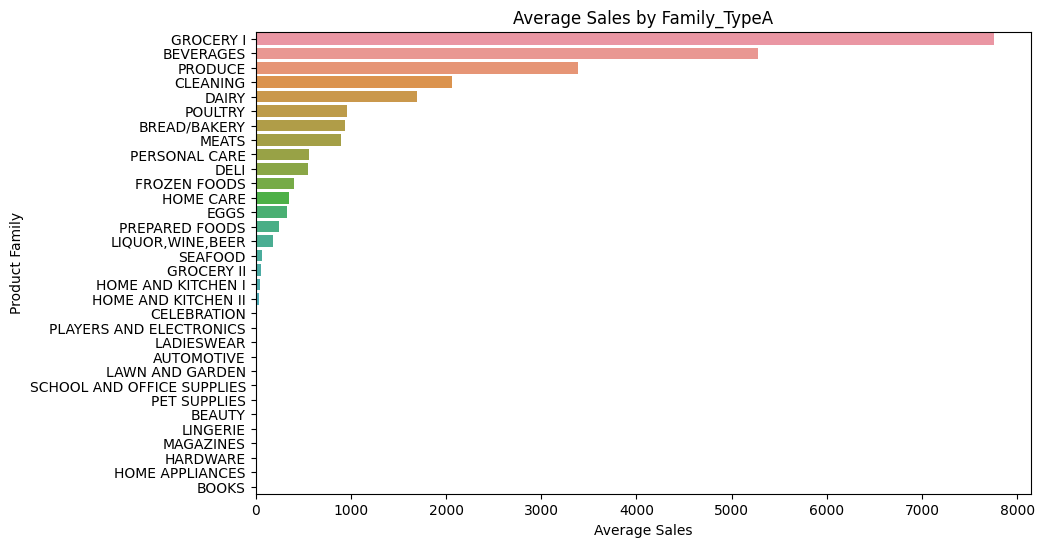

In [ ]:
### 각 품목별로 매출에 미치는 영향

# 각 family 별로 'sales'의 평균을 계산하고, 내림차순으로 정렬
average_sales_by_family = typeA.groupby('family')['sales'].mean().sort_values(ascending=False)

## 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='sales', y='family', data=typeA, order=average_sales_by_family.index, ci=None)

# 그래프 제목 및 레이블 설정
plt.title('Average Sales by Family_TypeA')
plt.xlabel('Average Sales')
plt.ylabel('Product Family')
plt.show()

- groceryI과 beverage가 매출의 대부분을 차지한다.

### **💚 onpromotion**

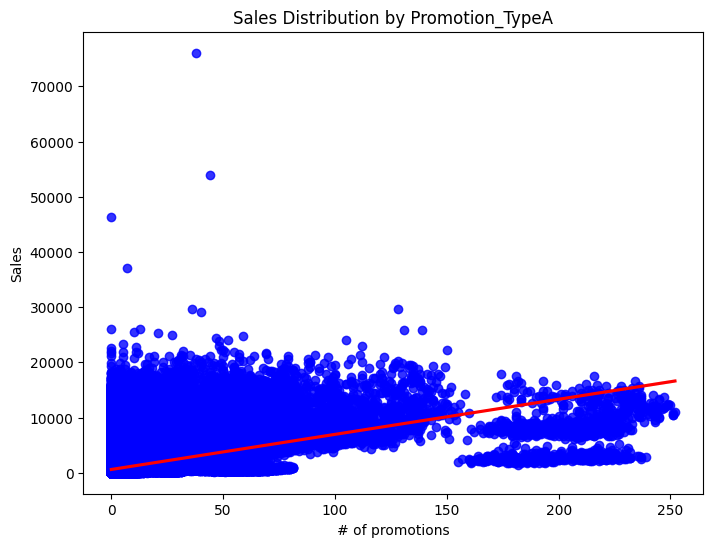

In [ ]:
plt.figure(figsize=(8, 6))

sns.regplot(x='onpromotion', y='sales', data=typeA, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

# 그래프 제목 및 레이블 설정
plt.title('Sales Distribution by Promotion_TypeA')
plt.xlabel('# of promotions')
plt.ylabel('Sales')
plt.show()

- 약한 양의 상관관계를 보인다.
- promotion되는 제품 수와 상관 없이 매출액이 큰 경우들이 존재함을 확인할 수 있다.

### **💙 state**

In [ ]:
# 고유한 주(state) 수

typeA['state'].unique()

array(['Pichincha', 'Guayas', 'Tungurahua', 'Manabi'], dtype=object)

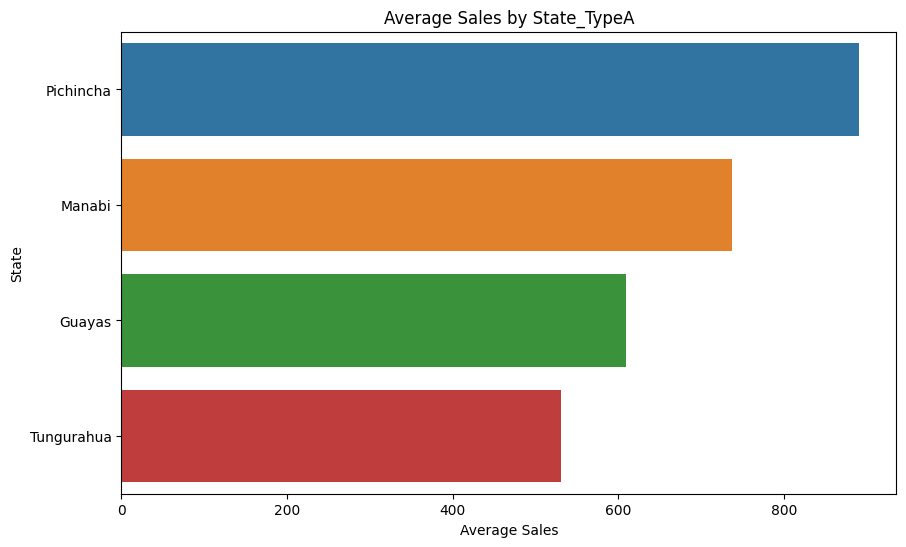

In [ ]:
### 각 주별 매출

# 각 state별로 'sales'의 평균을 계산하고, 내림차순으로 정렬
average_sales_by_family = typeA.groupby('state')['sales'].mean().sort_values(ascending=False)

## 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='sales', y='state', data=typeA, order=average_sales_by_family.index, ci=None)

# 그래프 제목 및 레이블 설정
plt.title('Average Sales by State_TypeA')
plt.xlabel('Average Sales')
plt.ylabel('State')
plt.show()

- 주마다 매출액에 차이가 있음을 확인할 수 있다.

### **💜 city**

In [ ]:
# 고유한 도시(city) 수

typeA['city'].unique()

array(['Quito', 'Guayaquil', 'Ambato', 'Manta'], dtype=object)

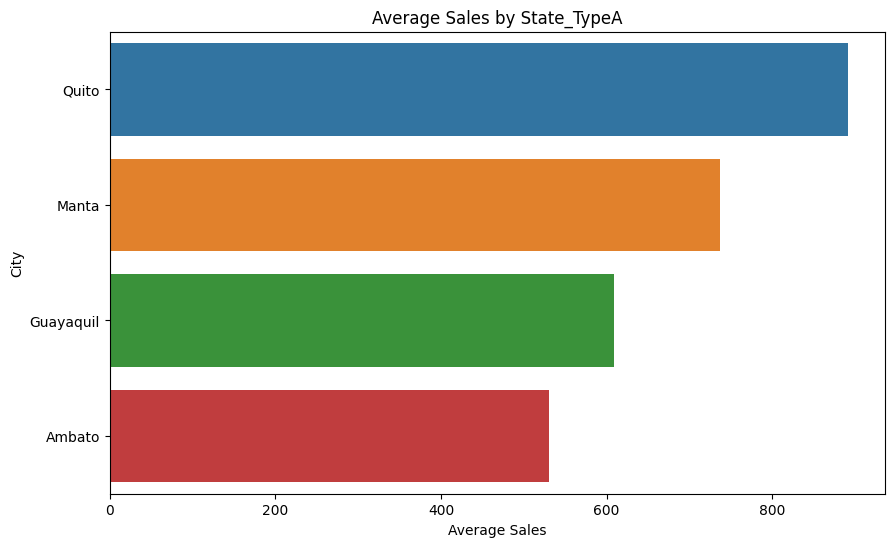

In [ ]:
### 각 도시별 매출

# 각 city별로 'sales'의 평균을 계산하고, 내림차순으로 정렬
average_sales_by_family = typeA.groupby('city')['sales'].mean().sort_values(ascending=False)

## 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='sales', y='city', data=typeA, order=average_sales_by_family.index, ci=None)

# 그래프 제목 및 레이블 설정
plt.title('Average Sales by State_TypeA')
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.show()

- 도시마다 매출액에 차이가 있음을 확인할 수 있다.

### **🤎dcoilwtico**

In [ ]:
import plotly.express as px

daily_oil_price = typeA.groupby("date")["dcoilwtico"].mean().reset_index()

# 그래프 그리기
fig = px.line(daily_oil_price, x="date", y="dcoilwtico", title="Daily DcoilWTICO Prices")
fig.show()

- 유가 변동 경향과 sales의 변동이 별 상관은 없어 보인다.(추세가 다름)

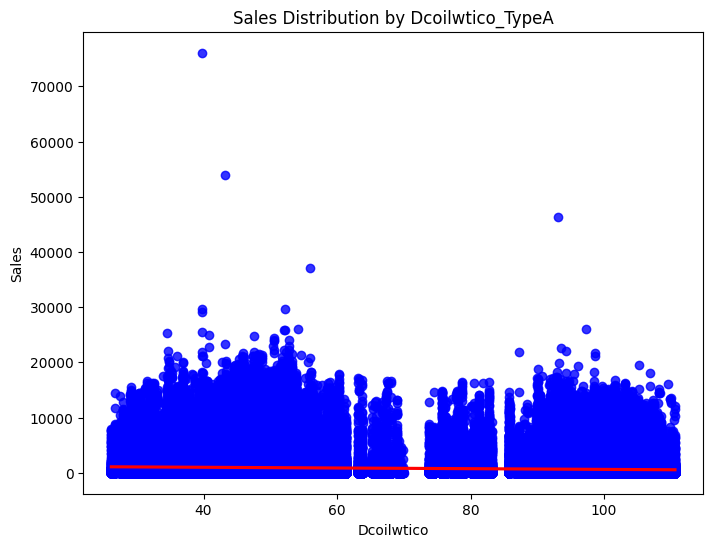

In [ ]:
plt.figure(figsize=(8, 6))

sns.regplot(x='dcoilwtico', y='sales', data=typeA, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

# 그래프 제목 및 레이블 설정
plt.title('Sales Distribution by Dcoilwtico_TypeA')
plt.xlabel('Dcoilwtico')
plt.ylabel('Sales')
plt.show()

- 정말 별 상관은 없어 보인다.
- 다만 유가가 70 전후에서 두 개의 그룹으로 확연히 분리되는 것을 확인할 수 있다.

In [ ]:
under70 = typeA.loc[typeA['dcoilwtico'] <= 70,:]
over70 = typeA.loc[typeA['dcoilwtico'] > 70,:]

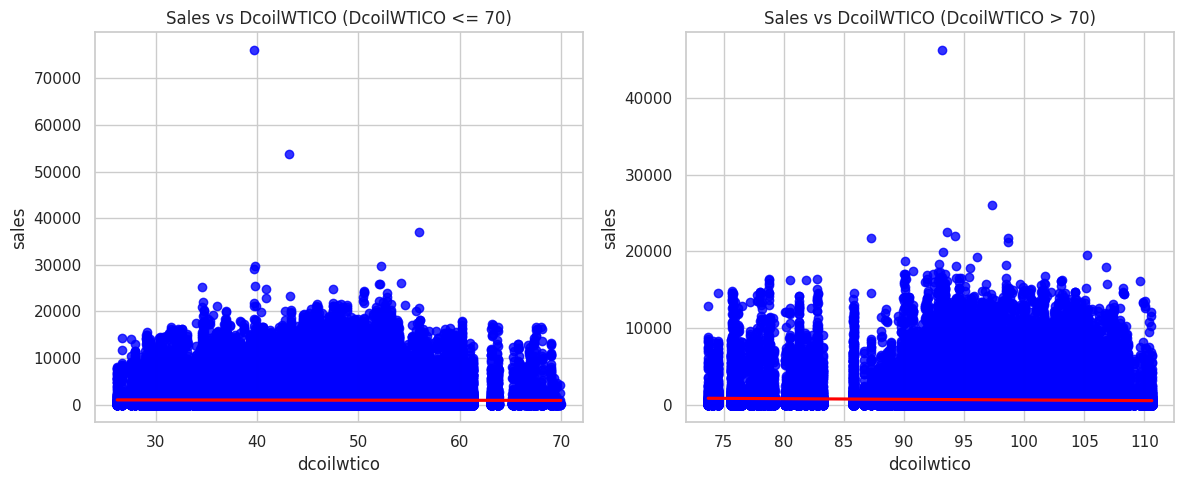

In [ ]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot regplot for 'dcoilwtico' <= 70
sns.regplot(x='dcoilwtico', y='sales', data=under70, ax=axes[0], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
axes[0].set_title('Sales vs DcoilWTICO (DcoilWTICO <= 70)')

# Plot regplot for 'dcoilwtico' > 70
sns.regplot(x='dcoilwtico', y='sales', data=over70, ax=axes[1], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
axes[1].set_title('Sales vs DcoilWTICO (DcoilWTICO > 70)')

# Adjust layout
plt.tight_layout()
plt.show()

- 차이가 나타나진 않는다..

### **💗 transactions**

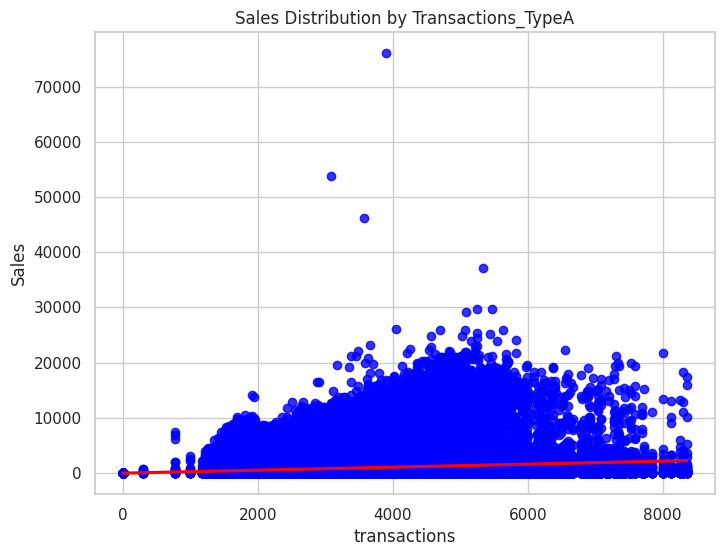

In [ ]:
plt.figure(figsize=(8, 6))

sns.regplot(x='transactions', y='sales', data=typeA, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

# 그래프 제목 및 레이블 설정
plt.title('Sales Distribution by Transactions_TypeA')
plt.xlabel('transactions')
plt.ylabel('Sales')
plt.show()

- 별..상관 관계는 없어 보인다만..

### **🤍 holiday**

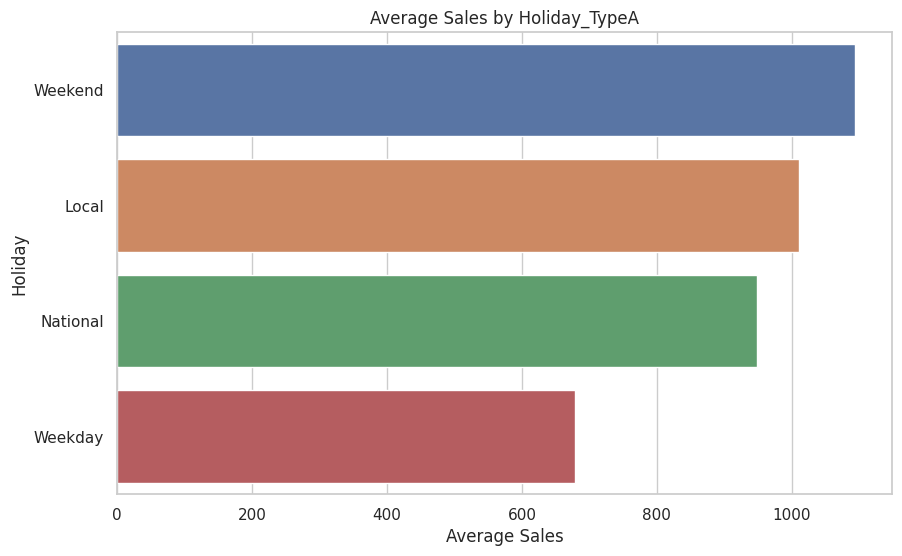

In [ ]:
### 휴일 유형별 매출

# 각 휴일 유형별로 'sales'의 평균을 계산하고, 내림차순으로 정렬
average_sales_by_holiday = typeA.groupby('holiday')['sales'].mean().sort_values(ascending=False)

## 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='sales', y='holiday', data=typeA, order=average_sales_by_holiday.index, ci=None)

# 그래프 제목 및 레이블 설정
plt.title('Average Sales by Holiday_TypeA')
plt.xlabel('Average Sales')
plt.ylabel('Holiday')
plt.show()

- 그냥 주말(공휴일은 제외됨)에 매출이 가장 좋다.

### **⭐Target 변수(Sales)**
- 여러 요인에 따라 매출이 어떻게 달라지는지 살펴보자.

#### **a) 시도표**

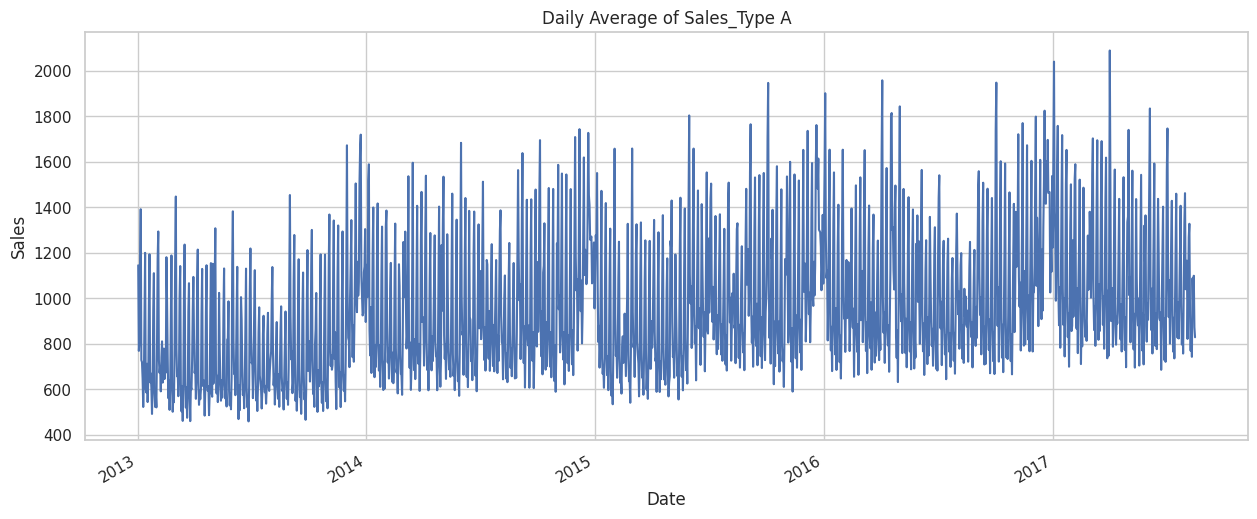

In [ ]:
### 휴업한 날의 데이터 제외
# sales가 0인 데이터 -> 휴업으로 인한 값 => 비정상 데이터이므로 제외

trainA = typeA[typeA['sales'] != 0]

# 일별 평균 계산
daily_average = trainA.groupby('date')['sales'].mean()

# 시각화
daily_average.plot(figsize=(15, 6))
plt.title('Daily Average of Sales_Type A')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

- 추세(Trend)
  - 우상향 추세를 보인다.
  - 향후에도 매출액이 증가할 것이라고 예측할 수 있다.
- 계절성(Seasonality)

- 순환성(Cyclic)

- 불규칙성(Irregularity)
  - 중간중간 휴업으로 인한 불규칙성을 보임
  - 특히 2013, 2014년 초에 급격한 매출 저하를 보이는 구간들이 존재

---

(+) 여기에 ACF, PACF 추가  
(+) 차분 계열 추가?(lag)  

#### **b) 시간 관련 변수**
- 시간과 관련된 파생 변수들을 생성해 보자.

In [ ]:
trainA['year'] = trainA['date'].dt.year # 연도
trainA['quarter'] = trainA['date'].dt.quarter # 분기별
trainA['month'] = trainA['date'].dt.month # 월
trainA['day_of_week'] = trainA['date'].dt.dayofweek # 요일

In [ ]:
trainA.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,cluster,dcoilwtico,transactions,holiday,year,quarter,month,day_of_week
1547,1547,2013-01-02,44,PERSONAL CARE,716.00,0.00,Quito,Pichincha,5,93.14,4821.00,Weekday,2013,1,1,2
1549,1549,2013-01-02,45,LAWN AND GARDEN,8.00,0.00,Quito,Pichincha,11,93.14,4208.00,Weekday,2013,1,1,2
1552,1552,2013-01-02,45,HOME APPLIANCES,2.00,0.00,Quito,Pichincha,11,93.14,4208.00,Weekday,2013,1,1,2
1556,1556,2013-01-02,45,GROCERY II,150.00,0.00,Quito,Pichincha,11,93.14,4208.00,Weekday,2013,1,1,2
1557,1557,2013-01-02,45,GROCERY I,11422.00,0.00,Quito,Pichincha,11,93.14,4208.00,Weekday,2013,1,1,2


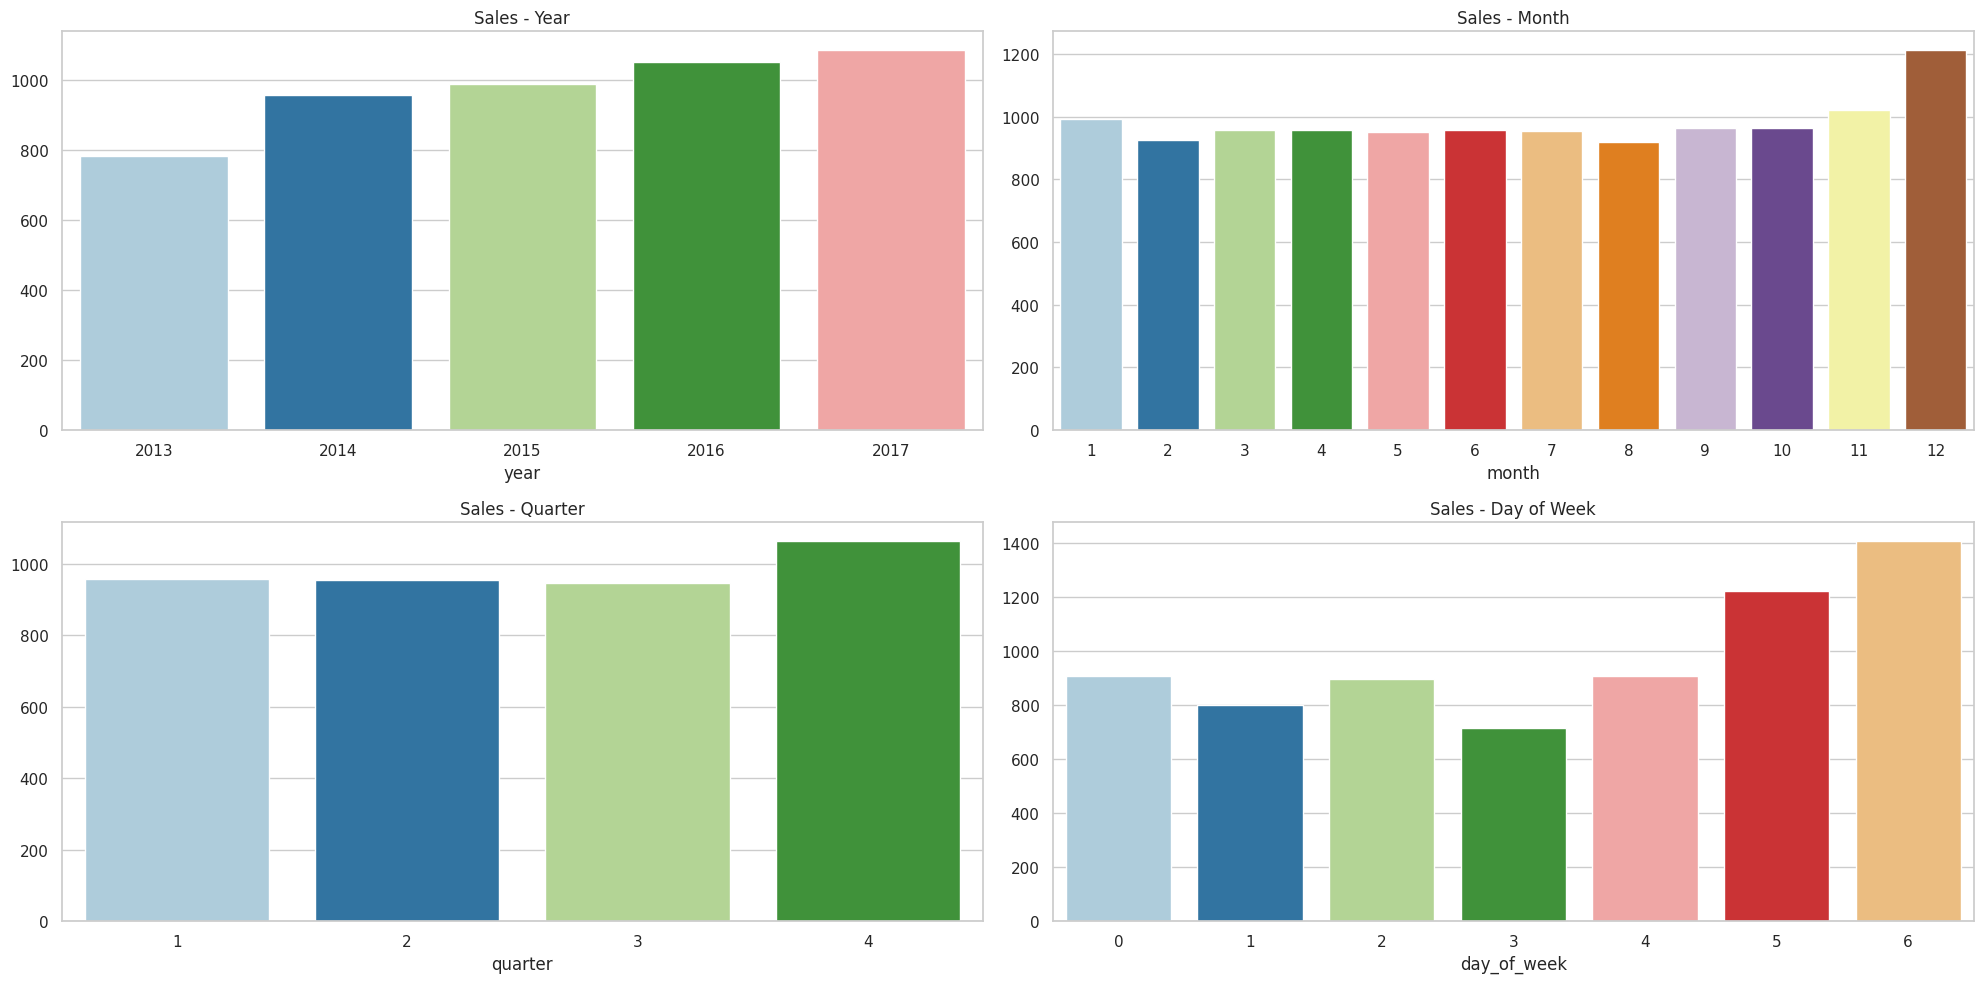

In [ ]:
### 평균 매출액으로 시각화
data_grouped_year = trainA.groupby(['year']).mean()['sales']
data_grouped_month = trainA.groupby(['month']).mean()['sales']
data_grouped_quarter = trainA.groupby(['quarter']).mean()['sales']
data_grouped_day = trainA.groupby(['day_of_week']).mean()['sales']


palette = sns.color_palette("Paired")


fig, axes = plt.subplots(2, 2, figsize=(20, 10))
# 연도별 매출
axes[0, 0].set_title('Sales - Year')
sns.barplot(x=data_grouped_year.index, y=data_grouped_year.values, ax=axes[0, 0], palette=palette)
# 월별 매출
axes[0, 1].set_title('Sales - Month')
sns.barplot(x=data_grouped_month.index, y=data_grouped_month.values, ax=axes[0, 1], palette=palette)
# 분기별 매출
axes[1, 0].set_title('Sales - Quarter')
sns.barplot(x=data_grouped_quarter.index, y=data_grouped_quarter.values, ax=axes[1, 0], palette=palette)
# 요일별 매출
axes[1, 1].set_title('Sales - Day of Week')
sns.barplot(x=data_grouped_day.index, y=data_grouped_day.values, ax=axes[1, 1], palette=palette)

plt.tight_layout()
plt.show()

**연도별 매출**
- 뒤로 갈수록 매출액이 점점 증가하고 있다.

**월별 & 분기별 매출**  
- 대체로 비슷한 경향을 보이나, 12월에 매출이 증가
- 4분기에 매출 증가

**요일별 매출**  
- 평일에 비해 주말의 매출액이 더 높다.

#### **c) 변수들 간의 상관관계**
- 상관계수는 수치형 변수들끼리만 비교 가능

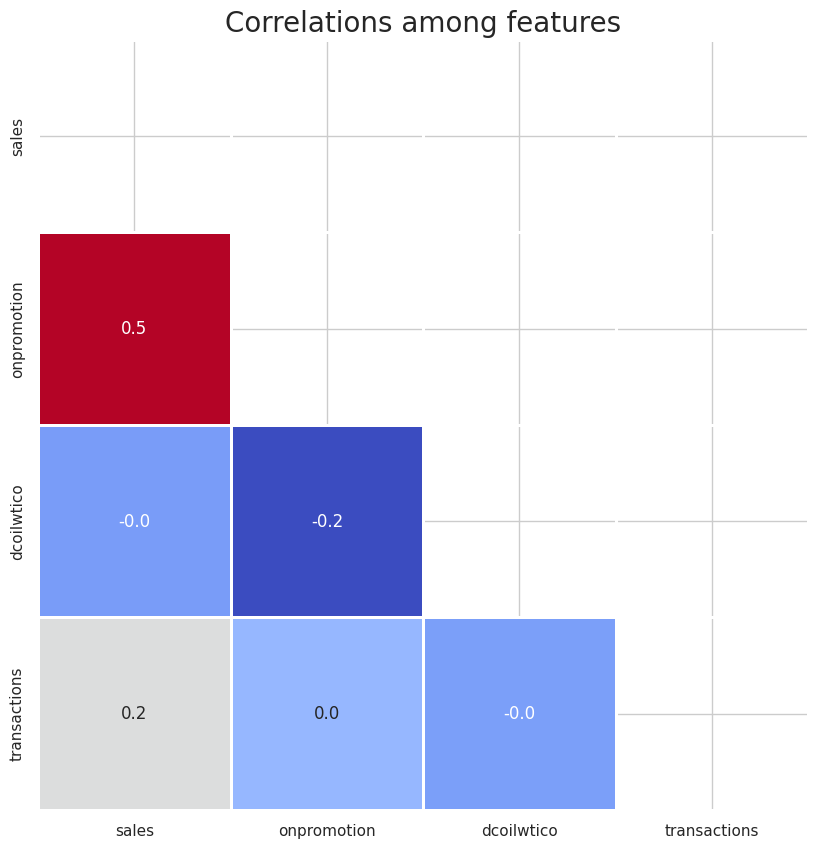

In [ ]:
num_ftrs = trainA[['sales', 'onpromotion','dcoilwtico','transactions']]

mask = np.triu(num_ftrs.corr())

# heatmap을 이용한 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(num_ftrs.corr(),
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)
plt.title("Correlations among features", fontsize=20)
plt.show()